Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-vgg16.ipynb)

## Code Modules, Classes & Functions

In [1]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch
from tensorflow import image as timage
import tensorflow_datasets as tfds
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn as tnn
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [2]:
class TData(tds):
    def __init__(self,x,y): 
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        train_img,train_lbl=self.x[index],self.y[index]
        return train_img,train_lbl
    def __len__(self):
        return self.y.shape[0]

In [3]:
def prepro_display(x,y,img_size):
    x=x.reshape(-1,3,img_size,img_size)
    y=y.reshape(-1)
    shuffle_ids=np.arange(N)
    np.random.RandomState(23).shuffle(shuffle_ids)
    x,y=x[shuffle_ids],y[shuffle_ids]
    x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
    y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [y_train.dtype,y_valid.dtype,y_test.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label shape','label type'])
    display(df)
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test]]
def display_examples(data_loader,img_size):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(10,3))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size,3))
        break

In [4]:
def model_acc(model,data_loader):
    model.eval()
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader,valid_loader,test_loader]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

## Data

In [5]:
splits='train'
tfds.disable_progress_bar()
(raws),metadata=\
tfds.load('cats_vs_dogs:4.0.0',split=splits,
          with_info=True,as_supervised=True)

In [6]:
img_size=32; N=23262; n=int(.2*N); i=0
images=np.zeros((N,img_size,img_size,3),
                dtype='float32')
labels=np.zeros((N,1),dtype='int32')
for img,lbl in raws.take(N):
    img=timage.resize(img,[img_size,img_size])
    images[i,:]=img.numpy()/255
    labels[i,:]=lbl; i+=1

In [7]:
[[x_train,x_valid,x_test],
 [y_train,y_valid,y_test]]=\
prepro_display(images,labels,img_size)

,train,valid,test
image shape,"(13958, 3, 32, 32)","(4652, 3, 32, 32)","(4652, 3, 32, 32)"
image type,float32,float32,float32
label shape,"(13958,)","(4652,)","(4652,)"
label type,int32,int32,int32


Image dimensions: torch.Size([128, 3, 32, 32])
Label dimensions: torch.Size([128])


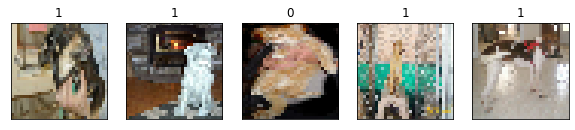

In [8]:
random_seed=12; batch_size=128
train=TData(x_train,y_train)
valid=TData(x_valid,y_valid)
test=TData(x_test,y_test)
train_loader=tdl(dataset=train,shuffle=True,
                 batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True,
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=True,
                 batch_size=batch_size)
display_examples(valid_loader,img_size)

## VGG16

In [9]:
class VGG16(tnn.Module):
    def __init__(self,num_classes):
        super(VGG16,self).__init__()
        self.block1=tnn.Sequential(
            tnn.Conv2d(in_channels=3,out_channels=64,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1), 
            tnn.ReLU(),
            tnn.Conv2d(in_channels=64,out_channels=64,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=(2,2),
                          stride=(2,2)) )       
        self.block2=tnn.Sequential(
            tnn.Conv2d(in_channels=64,out_channels=128,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.Conv2d(in_channels=128,out_channels=128,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=(2,2),
                          stride=(2,2)) )
        self.block3=tnn.Sequential(
            tnn.Conv2d(in_channels=128,out_channels=256,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.Conv2d(in_channels=256,out_channels=256,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),        
            tnn.Conv2d(in_channels=256,out_channels=256,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.Conv2d(in_channels=256,out_channels=256,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=(2,2),
                          stride=(2,2)) )                  
        self.block4=tnn.Sequential(
            tnn.Conv2d(in_channels=256,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),        
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),        
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),   
            tnn.MaxPool2d(kernel_size=(2,2),
                          stride=(2,2)) )        
        self.block5=tnn.Sequential(
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),            
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),            
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),   
            tnn.MaxPool2d(kernel_size=(2,2),
                          stride=(2,2)) )        
        self.classifier=tnn.Sequential(
            tnn.Linear(512,4096),tnn.ReLU(),   
            tnn.Linear(4096,4096),tnn.ReLU(),
            tnn.Linear(4096,num_classes) )        
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                m.weight.detach().normal_(0,.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m,torch.nn.Linear):
                m.weight.detach().normal_(0,.05)
                m.bias.detach().detach().zero_()               
    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        logits=self.classifier(x.view(-1,512))
        probs=tnn.functional.softmax(logits,dim=1)
        return logits,probs

## Training

In [10]:
num_classes=2; learning_rate=.001
model=VGG16(num_classes)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [11]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets.long())
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader),
                   model_acc(model,valid_loader)))

In [12]:
%train_run 50

Epoch: 001/050 | Batch 000/109 | Cost: 939.4967
Epoch: 001/050 | Batch 050/109 | Cost: 0.7093
Epoch: 001/050 | Batch 100/109 | Cost: 0.6896
Epoch: 001/050 train acc: 50.19% valid acc: 51.48%
Epoch: 002/050 | Batch 000/109 | Cost: 0.7295
Epoch: 002/050 | Batch 050/109 | Cost: 0.6732
Epoch: 002/050 | Batch 100/109 | Cost: 0.6797
Epoch: 002/050 train acc: 55.60% valid acc: 54.75%
Epoch: 003/050 | Batch 000/109 | Cost: 0.6822
Epoch: 003/050 | Batch 050/109 | Cost: 0.6866
Epoch: 003/050 | Batch 100/109 | Cost: 0.6824
Epoch: 003/050 train acc: 59.86% valid acc: 58.68%
Epoch: 004/050 | Batch 000/109 | Cost: 0.6783
Epoch: 004/050 | Batch 050/109 | Cost: 0.6880
Epoch: 004/050 | Batch 100/109 | Cost: 0.7754
Epoch: 004/050 train acc: 53.44% valid acc: 51.78%
Epoch: 005/050 | Batch 000/109 | Cost: 0.6868
Epoch: 005/050 | Batch 050/109 | Cost: 0.6779
Epoch: 005/050 | Batch 100/109 | Cost: 0.6804
Epoch: 005/050 train acc: 50.91% valid acc: 49.96%
Epoch: 006/050 | Batch 000/109 | Cost: 0.6701
Epoch: 

In [13]:
%print_acc 1

Train accuracy: 93.6309%
Valid accuracy: 63.1341%
Test accuracy: 62.3173%
